<span style="font-size:5em;">Titanic Dataset</span>

**Michał M.**

# Introduction
This is my first Kaggle kernel. I choosed the well-known Titanic dataset, I just wanted to imporve my python skills. I am advenced R user, but have minor experience with *the snake*.

To all of you who does not know the *Titanic* dataset, it is one of the most popular Kaggle competition. The data contais information about Titanic passengers, the main objective of this task is to predict which people survived the disater.

This notebook follows four main parts:

* Data import
* Missing values imputation
* Feature analysis
* Feature engineering
* Modeling

We began with importing necessary libraries.

In [1]:
%matplotlib inline

import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, learning_curve, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

sns.set_style('whitegrid')

# Data load and initial checks

According to the provided data dictionary, variables could be descibed as follows.

| Variable |                 Definition                 |                       Key                      |
|----------|--------------------------------------------|------------------------------------------------|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

There are 11 independent variables.

## Data import

Data are provided in typical for Kaggle way - two datasets, *train* and *test*.

In [2]:
# load data
train = pd.read_csv('./01 Data/train.csv')
test = pd.read_csv('./01 Data/test.csv')

# preview
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Joining train and train sets

In [3]:
# join train and test datasets in order to obtain the same number of features
train_len = len(train)
full_dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

## Data integrity

In [4]:
# fill empty and Nan's values with NaN
dataset = full_dataset.fillna(np.nan)

# null values
dataset.isnull().sum().sort_values(ascending=False)

Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
Ticket            0
Parch             0
SibSp             0
Sex               0
Name              0
Pclass            0
PassengerId       0
dtype: int64

There were a lot missing values in the **cabin** column (almost 80%), what probably would make it hard to use. Missing values in **Survived** column come from the *test* dataset. There were some missing values for **Age** and we would try to fill them with more advanced method, **Embraked** and **Fare** variables could be filled using some standard approach like *mean* or *median*. 

In [5]:
train.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [6]:
train.info()
train.drop(['PassengerId'], axis=1).describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Filling missing values

We handled missing values in several diffrent ways and presented it below.

## Embarked and Fare

 There we two observations with `Null` value in the **Embarked** column.

In [7]:
dataset['Embarked'].isnull().sum()

2

We filled it with most common value, i.e. 'S'.

In [8]:
dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode())

Recall, there was one observation with `Null` value in the **Fare** column.

In [9]:
dataset['Fare'].isnull().sum()

1

We fill it with median value.

In [10]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

## Age

Variable **Age** contains 256 missing values which should be somehow filled in order to preserve usability of **Age** variable. 

Let's look at the variables most correlated with the **Age** and its distribution among them.  

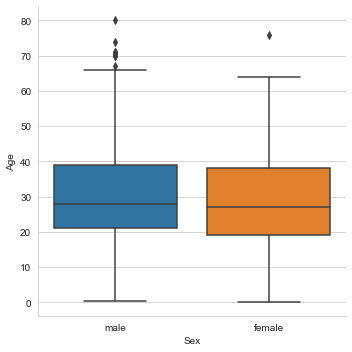

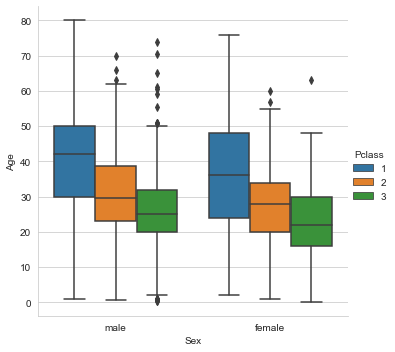

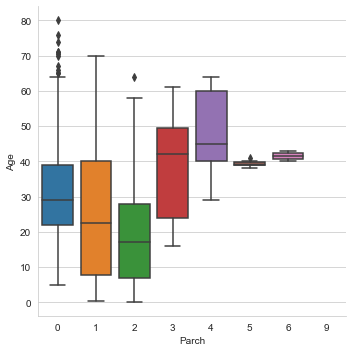

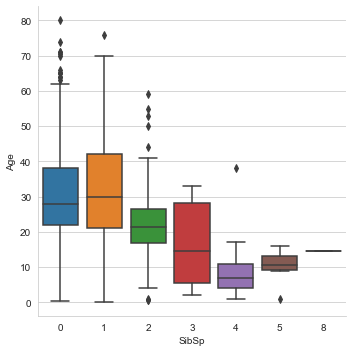

In [11]:
#  Age vs Sex, Parch, Pclass and SibSP (whole dataset)
p = sns.catplot(y='Age', x='Sex', data=dataset, kind='box')
p = sns.catplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
p = sns.catplot(y='Age', x='Parch', data=dataset, kind='box')
p = sns.catplot(y='Age', x='SibSp', data=dataset, kind='box')

In [12]:
# fill Age with the median age of similar rows according to Pclass, Parch and SibSp
dataset['Age'] = dataset['Age'].fillna(dataset.groupby(['SibSp', 'Parch', 'Pclass'])['Age'].transform('median'))
dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())

train['Age'] = dataset.loc[:train.shape[0]-1, 'Age']

# Variables exploration

## Numerical variables

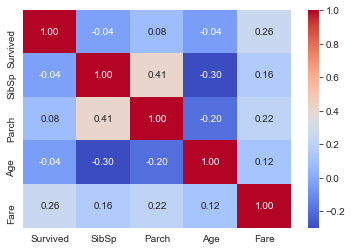

In [13]:
# correlation matrix
p = sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(), annot=True, fmt = '.2f', cmap = 'coolwarm')

There is no obvious relationship between variable **Survived** and other dependent, numerical variables.

### SibSp

*number of siblings/spouses aboard the Titanic*

The dataset defines family relations in this way:
 * Sibling = brother, sister, stepbrother, stepsister;
 * Spouse = husband, wife (mistresses and fiancés were ignored).

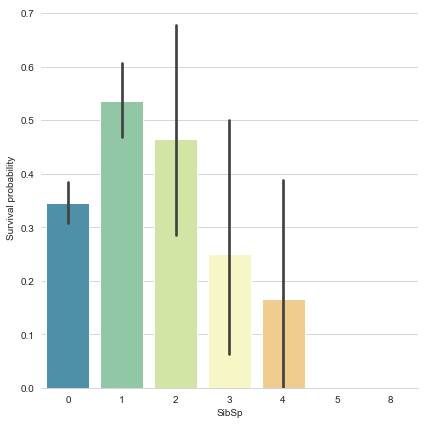

In [14]:
# SibSp vs Survived
p = sns.catplot(x='SibSp', y='Survived', data=train, kind='bar', height = 6, palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Survival probability')

Seems that that higher number of siblings/spouses decrease the chance of survival. As the passengers with **SibSP** equal to one, two or zero have the highest probability of survival we could suspect that being a part of large family decrease your chance of survival the disaster.

### Parch

*number of parents/children aboard the Titanic*

The dataset defines family relations in this way:
 * Parent = mother, father;
 * Child = daughter, son, stepdaughter, stepson.
 
Some children travelled only with a nanny, therefore parch=0 for them.

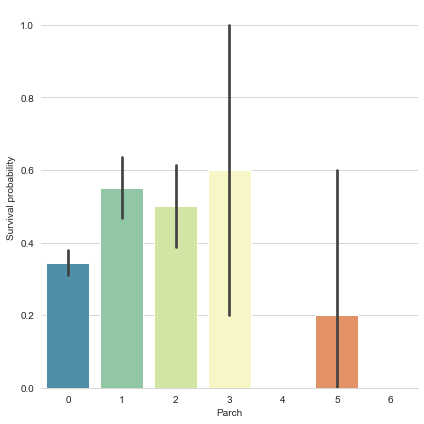

In [15]:
# Parch vs Survived
p = sns.catplot(x='Parch', y='Survived', data=train, kind='bar', height = 6, palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Survival probability')

There is similiar conclusion as in case of **SibSp** variable - little families (**Parch** below 3) seems to have higher probability of survival. Passengers with larger number of relatives of different generations has higher variance of **Survived** variable. 

We use this observation in a *Feature engineering* part. 

### Age

*Age in years*

Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

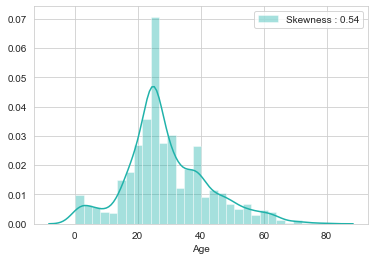

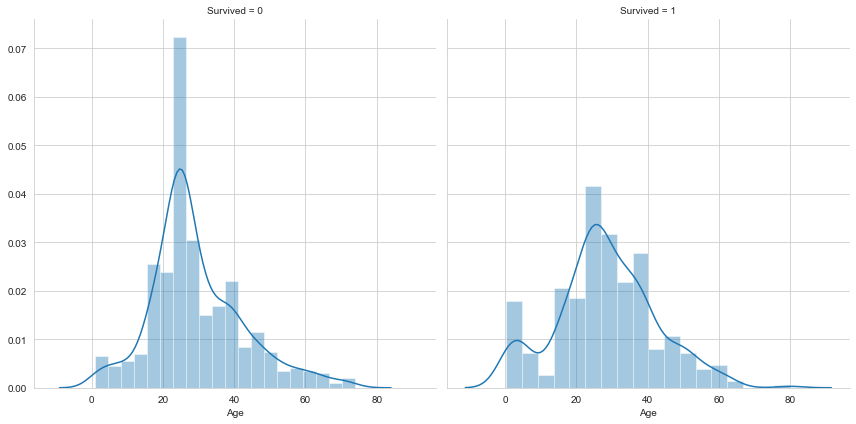

In [16]:
# Age distribution
p = sns.distplot(dataset['Age'], color='LightSeaGreen', label='Skewness : %.2f'%(dataset['Age'].skew()))
p = p.legend(loc='best')

# Age vs Survived
p = sns.FacetGrid(train, col='Survived', height = 6)
p = p.map(sns.distplot, 'Age')

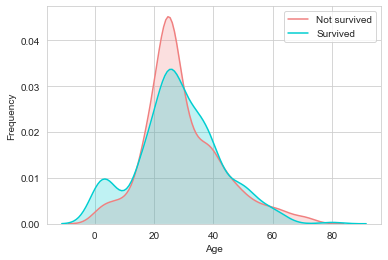

In [17]:
# comparison on single plot
p = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color='lightcoral', shade=True)
p = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax=p, color='darkturquoise', shade=True)
p.set_xlabel('Age')
p.set_ylabel('Frequency')
p = p.legend(['Not survived','Survived'])

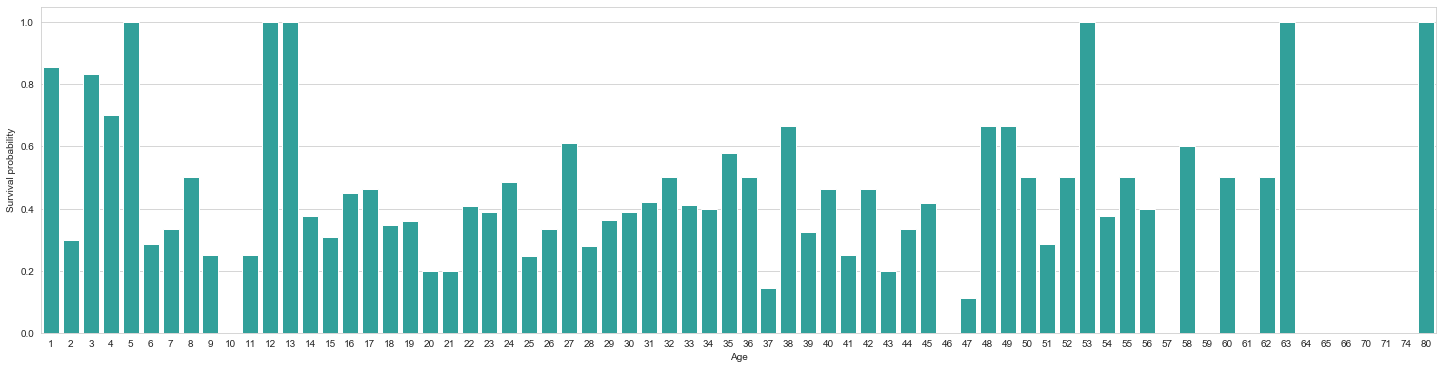

In [18]:
plt.figure(figsize=(25,6))

avg_survival_by_age = train[['Age', 'Survived']].apply(np.ceil).groupby(['Age'], as_index=False).mean()
avg_survival_by_age[['Age']] = avg_survival_by_age[['Age']].astype(int)
p = sns.barplot(x='Age', y='Survived', data=avg_survival_by_age, color='LightSeaGreen')
p = p.set_ylabel('Survival probability')

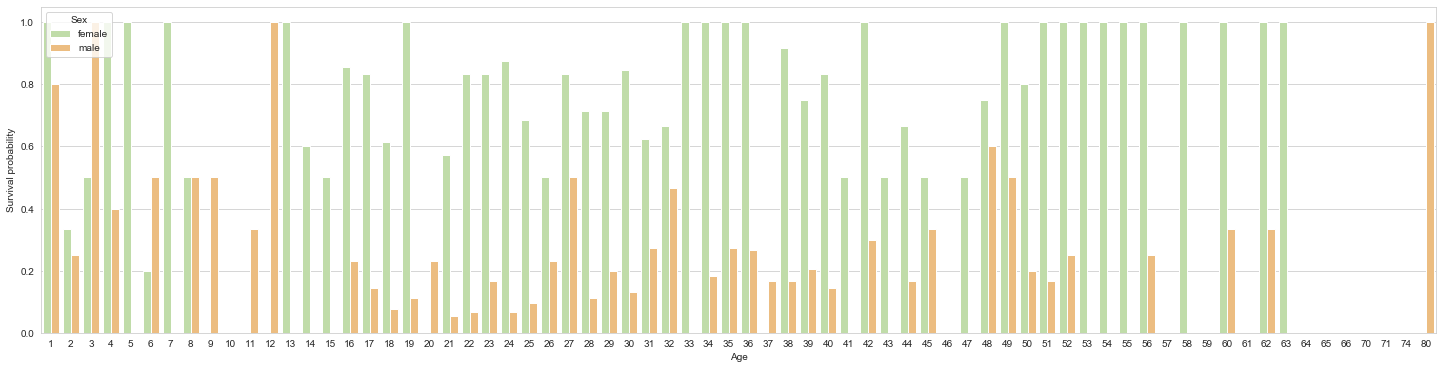

In [19]:
plt.figure(figsize=(25,6))

avg_survival_by_age = train[['Age', 'Survived', 'Sex']].apply(lambda x: np.ceil(x) if x.name == 'Age' else x).groupby(['Age', 'Sex'], as_index=False).mean()
avg_survival_by_age[['Age']] = avg_survival_by_age[['Age']].astype(int)
p = sns.barplot(x='Age', y='Survived', hue='Sex', data=avg_survival_by_age, palette='Spectral_r')
p = p.set_ylabel('Survival probability')

These two plot confirms what we know about Titanic disaster from historical sources - *Childern and ladies first!*. There is visible diffrrence among sexes in the survival probability, moreover younger passengers have a higher chance of survival in comparison to older ones.

### Fare

*Passenger fare*

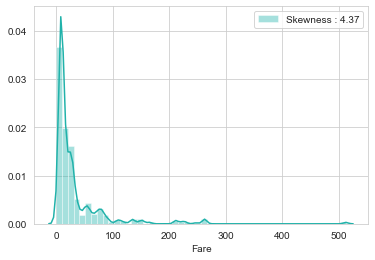

In [20]:
# Fare distribution over whole data
p = sns.distplot(dataset['Fare'], color='LightSeaGreen', label='Skewness : %.2f'%(dataset['Fare'].skew()))
p = p.legend(loc='best')

Fare distribution is very skewed, we tried to *unskew* it using logarithm.

In [21]:
# log function on Fare to reduce skewness
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
train['Fare'] = train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

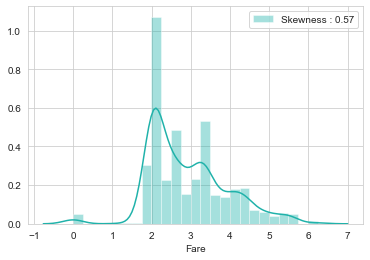

In [22]:
p = sns.distplot(dataset['Fare'], color='LightSeaGreen', label='Skewness : %.2f'%(dataset['Fare'].skew()))
p = p.legend(loc='best')

After tranformation it looks much better, no other modifications are curently needed. Let plot **Fare** variable and its distribution with relation to **Survival probability**.

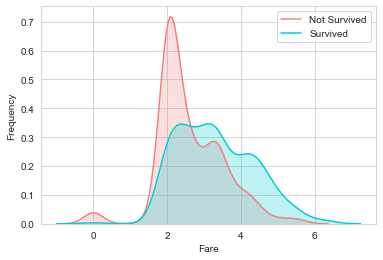

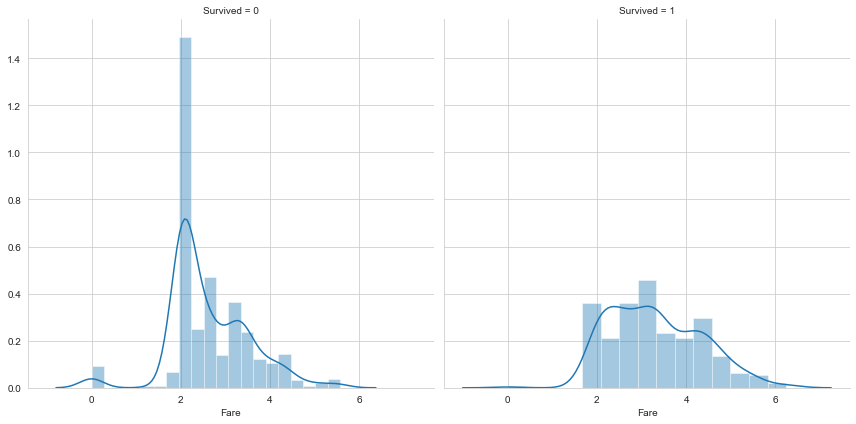

In [23]:
# comparison on single plot
p = sns.kdeplot(train['Fare'][(train['Survived'] == 0) & (train['Age'].notnull())], color='lightcoral', shade=True)
p = sns.kdeplot(train['Fare'][(train['Survived'] == 1) & (train['Age'].notnull())], ax=p, color='darkturquoise', shade=True)
p.set_xlabel('Fare')
p.set_ylabel('Frequency')
p = p.legend(['Not Survived','Survived'])

# Age vs Survived
p = sns.FacetGrid(train, col='Survived', height = 6)
p = p.map(sns.distplot, 'Fare')

There is slight, visible diffrence beetween distributions.

## Categorical Variables

Now we proceed to categorical variables and their distribution with relation to variable *Survived*

### Sex

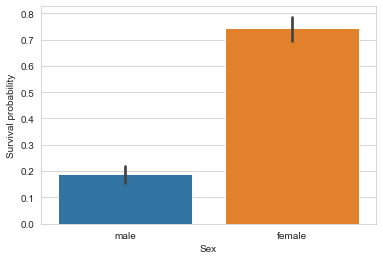

In [24]:
p = sns.barplot(x='Sex' ,y='Survived', data=train)
p = p.set_ylabel('Survival probability')

It is visible, that **sex** play import role in survival of the underlying passenger. 

In [25]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


#### Pclass

*Ticket class*

A proxy for socio-economic status (SES):
 * 1st = Upper
 * 2nd = Middle
 * 3rd = Lower

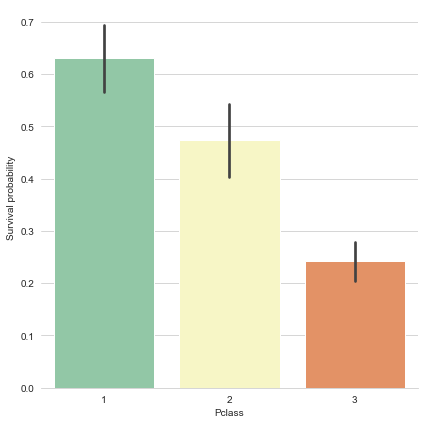

In [26]:
# Pclass vs Survived
p = sns.catplot(x='Pclass', y='Survived', data=train, kind='bar', height=6 , palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Survival probability')

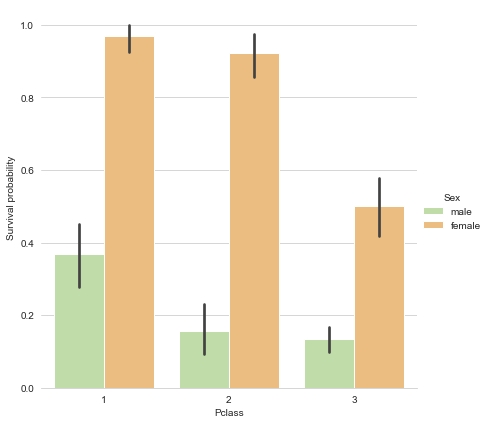

In [27]:
# Pclass vs Survived vs Sex
p = sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train, height=6, kind='bar', palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Survival probability')

### Embarked

*Port of Embarkation*

A port of embarkation coded as:
 * C = Cherbourg;
 * Q = Queenstown;
 * S = Southampton.

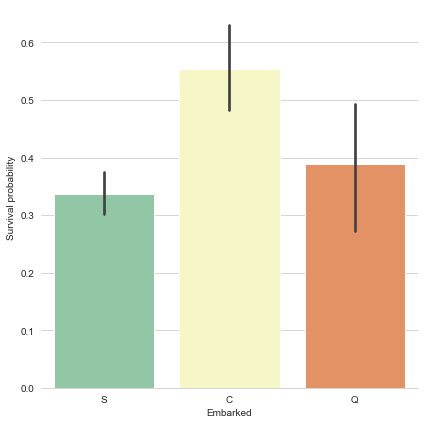

In [28]:
# Embarked vs Survived
p = sns.catplot(x='Embarked', y='Survived', data=train, kind='bar', height=6 , palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Survival probability')

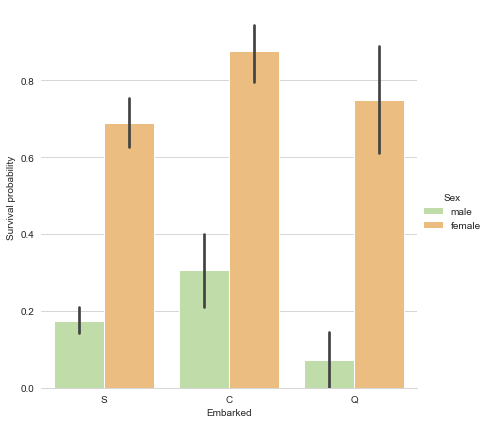

In [29]:
# Embarked vs Survived vs Sex
p = sns.catplot(x='Embarked', y='Survived', hue='Sex', data=train, height=6, kind='bar', palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Survival probability')

It seems that passenger coming from Cherbourg have more chance to survive.

Let's check proportion of classes among all three ports.

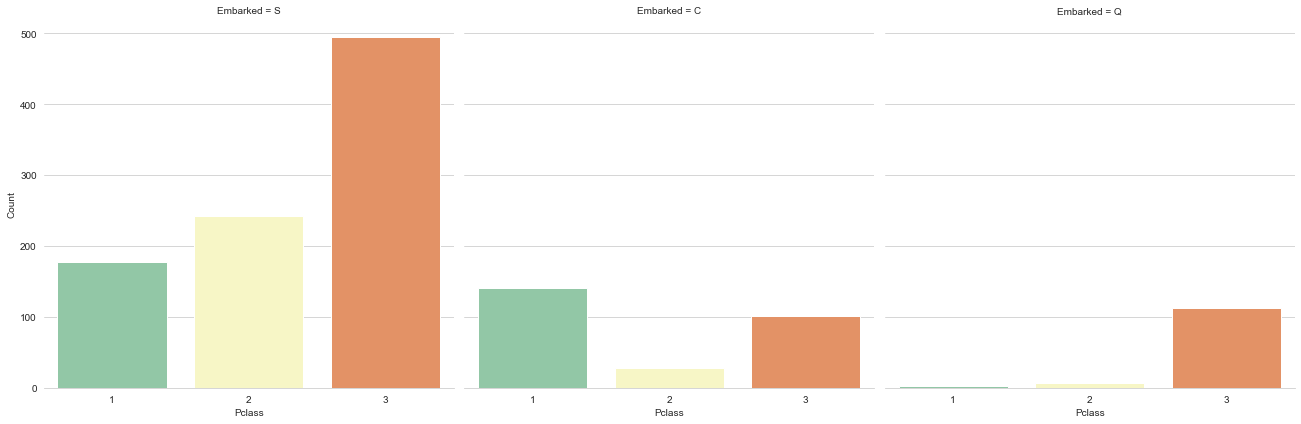

In [30]:
# Pclass vs Embarked 
p = sns.catplot('Pclass', col='Embarked', data=dataset, height=6, kind='count', palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Count')

We can conclude that the third class is the most frequent for passenger coming from Southampton and Queenstown, whereas Cherbourg passengers are mostly in first class which have the highest survival rate.

We can't explain why first class has an higher survival rate. Probably first class passengers were prioritised during the evacuation due to their influence.

# Feature engineering

## Family size

According to the Kaggle data dictionary, both **SibSp** and **Parch** relate to traveling with family. We can combine both to introduce variable **Family size**, deonted **FamS**. We suppose that large families might be hard to be rescued during disaster. 

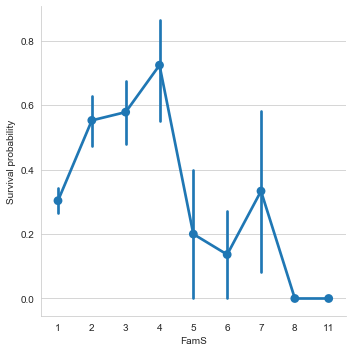

In [31]:
# family size descriptor from SibSp and Parch
dataset['FamS'] = dataset['SibSp'] + dataset['Parch'] + 1
train['FamS'] = train['SibSp'] + train['Parch'] + 1

p = sns.catplot(x='FamS', y='Survived', data = train, kind = 'point')
p = p.set_ylabels('Survival probability')

We add additional categorical variable to aggregate family size.

In [32]:
# Create new feature of family size
def family_size(peers):
    size = 'Large'
    if peers == 1:
        size = 'Single'
    elif peers <= 3:
        size = 'Small'
    elif peers == 4:
        size = 'Medium'
    return size

dataset['FamSCat'] = dataset['FamS'].map(family_size)
train['FamSCat'] = train['FamS'].map(family_size)

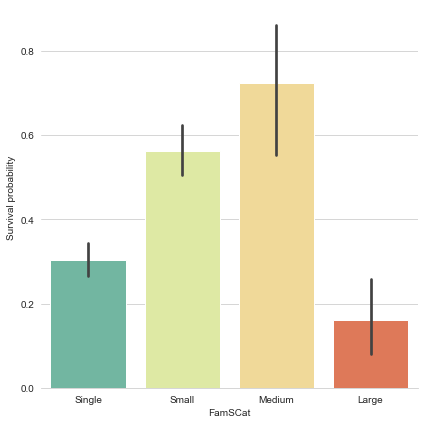

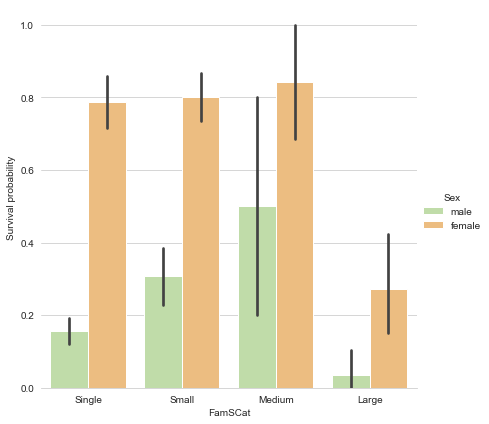

In [33]:
# FamSCat vs Survived
p = sns.catplot(x='FamSCat', y='Survived', data=train, height=6, kind='bar', palette='Spectral_r', order=['Single', 'Small', 'Medium', 'Large'])
p.despine(left=True)
p = p.set_ylabels('Survival probability')

# FamSCat vs Survived vs Sex
p = sns.catplot(x='FamSCat', y='Survived', hue='Sex', data=train, height=6, kind='bar', palette='Spectral_r', order=['Single', 'Small', 'Medium', 'Large'])
p.despine(left=True)
p = p.set_ylabels('Survival probability')

Obtained variable migh be usefull during forecasting as there is visible diffrence among the groups.

## Title

We try to extract title from the **Name** colum.

In [34]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [35]:
# Title from Name
dataset['Title'] = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

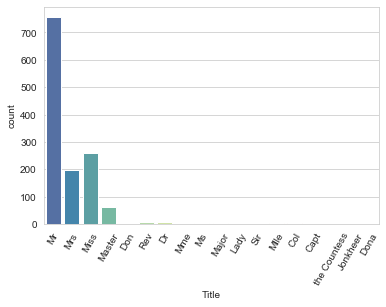

In [36]:
p = sns.countplot(x='Title', data=dataset, palette='Spectral_r')
p = plt.setp(p.get_xticklabels(), rotation=60) 

In [37]:
# convert to categorical values 
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].replace(['Miss', 'Ms', 'Mme', 'Mlle', 'Mrs'], 'Ladys_title')
dataset['Title'].head()

0             Mr
1    Ladys_title
2    Ladys_title
3    Ladys_title
4             Mr
Name: Title, dtype: object

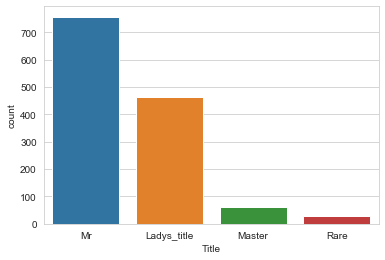

In [38]:
p = sns.countplot(dataset['Title'])

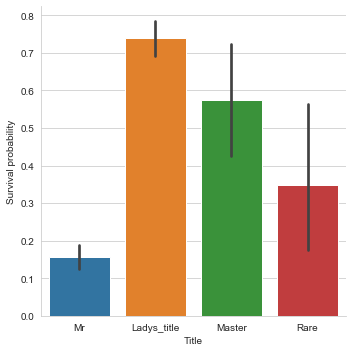

In [39]:
p = sns.catplot(x='Title', y='Survived', data=dataset, kind='bar')
p = p.set_ylabels('Survival probability')

# Modelling 

## Dummy variables/train set preparation

Before start of modelling we create dummy variables for all categorical variables we had in the dataset.

In [40]:
dataset.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamS', 'FamSCat',
       'Title'],
      dtype='object')

In [41]:
dataset.loc[:,'Pclass'] = dataset.loc[:,'Pclass'].astype('category')
dataset_final = pd.get_dummies(dataset.drop(labels=['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=False), prefix=['Pclass', 'Sex','Embarked', 'FamSCat', 'Title'])
dataset_final.head()

,Survived,Age,SibSp,Parch,Fare,FamS,Pclass_1,Pclass_2,Pclass_3,Sex_female,...,Embarked_Q,Embarked_S,FamSCat_Large,FamSCat_Medium,FamSCat_Single,FamSCat_Small,Title_Ladys_title,Title_Master,Title_Mr,Title_Rare
0,0.0,22.0,1,0,1.981001,2,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
1,1.0,38.0,1,0,4.266662,2,1,0,0,1,...,0,0,0,0,0,1,1,0,0,0
2,1.0,26.0,0,0,2.070022,1,0,0,1,1,...,0,1,0,0,1,0,1,0,0,0
3,1.0,35.0,1,0,3.972177,2,1,0,0,1,...,0,1,0,0,0,1,1,0,0,0
4,0.0,35.0,0,0,2.085672,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0


In [42]:
train_final = dataset_final.iloc[:train.shape[0]-1, ]
test_final = dataset_final.iloc[train.shape[0]:, 1:]

In [43]:
#ignore warning
train_final.loc[:,'Survived'] = train_final.loc[:,'Survived'].astype(int)

Y_train = train_final.iloc[:,0]
X_train = train_final.iloc[:,1:]

C:\Users\Michal\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Fast modelling

We will present different approaches to model fitting. At first we fit simple models without any additional steps, later we add scaling and in the last approach we also add *PCA*

The general pipeline for modeling looks as follows:

*scaler* → *PCA* → *ML algorithm*.

In [44]:
# CV
kfold = StratifiedKFold(n_splits=24)

In [45]:
# aggregated testing
random_state = 2137

classifiers = []
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(QuadraticDiscriminantAnalysis())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(XGBClassifier(random_state=random_state))
classifiers.append(GaussianNB())
classifiers.append(GaussianProcessClassifier(random_state=random_state))

In [46]:
cv_results = []

for classifier in classifiers:
    cv_results.append(cross_val_score(Pipeline([('scaler', StandardScaler()),
                                                ('classifier', classifier)]), X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=-1))      

cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'Algorithm':['RandomForest', 
                                    'AdaBoost',
                                    'GradientBoosting',
                                    'ExtraTrees',
                                    'LDA',
                                    'QDA',
                                    'LogisticRegression',
                                    'kNN',
                                    'DecisionTree',
                                    'MultipleLayerPerceptron',
                                    'SVC',
                                    'XGBoost',
                                    'GaussianNB',
                                    'GaussianProcess'
                                   ], 
                       'CrossValMeans':cv_means, 'CrossValErrors':cv_std})

In [47]:
cv_res.sort_values(by=['CrossValMeans'], ascending=False, inplace=True)
cv_res.reset_index(drop=True, inplace=True)
cv_res

,Algorithm,CrossValMeans,CrossValErrors
0,GradientBoosting,0.835971,0.070424
1,LDA,0.830311,0.053560
2,LogisticRegression,0.825836,0.055364
3,XGBoost,0.820235,0.061486
4,GaussianProcess,0.819079,0.068129
5,SVC,0.816827,0.062157
6,MultipleLayerPerceptron,0.814634,0.064832
7,GaussianNB,0.813508,0.058948
8,RandomForest,0.811344,0.052856
9,kNN,0.806840,0.062602


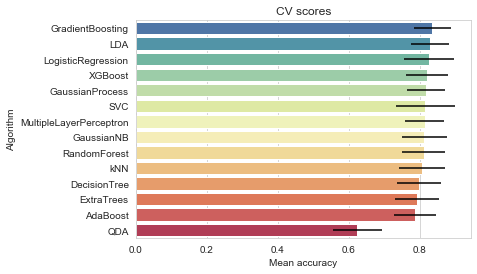

In [48]:
p = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Spectral_r',orient='h', **{'xerr':cv_std})
p.set_xlabel('Mean accuracy')
p = p.set_title('CV scores')

We choose the LDA, Logistic regression, MLP, and the Gradient boosting classifiers for the further tunning and ensamble modeling modeling. 
We also choose SVM just to check whether we are be able to tunning it well.

## (Hyper)parameter tunning

We would perform grid search to find best hyperparameters for all algorithms.

### Random forest

In [49]:
# RF tunning 

# search grid for optimal parameters
rf_param_grid = {'classifier__n_estimators': [150],             # np.arange(50, 255, 50)
                 'classifier__max_depth': [10],                 # None, 5, 10, 15, 20   
                 'classifier__min_samples_split': [28],         # 2, 4, 8, 12, 16, 20, 24, 28
                 'classifier__min_samples_leaf': [5],           # 1, 5, 10, 15, 20
                 'classifier__min_weight_fraction_leaf': [0.0], # 0.0, 0.1
                 'classifier__max_features': [10],              # 'auto', 'log2', 1, 3, 5, 10, 15   
                 'classifier__bootstrap': [True]                # True, False
                }


gs_rf = GridSearchCV(Pipeline([('scaler', StandardScaler()),
                               ('classifier', RandomForestClassifier())]),
                     param_grid=rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gs_rf.fit(X_train, Y_train)

rf_best = gs_rf.best_estimator_

# best score
gs_rf.best_score_

Fitting 24 folds for each of 1 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.9s finished


0.835970839260313

### AdaBoost

In [50]:
# AdaBoost tunning 

# search grid for optimal parameters
ada_param_grid = {"classifier__n_estimators": [200],  # np.arange(100, 255, 25)
                  "classifier__learning_rate": [0.05] # 0.025, 0.05, 0.1, 0.25, 0.5, 1, 1.5
                 }

gs_ada = GridSearchCV(Pipeline([('scaler', StandardScaler()),
                                ('classifier', AdaBoostClassifier())]),
                     param_grid=ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gs_ada.fit(X_train, Y_train)

ada_best = gs_ada.best_estimator_

# best score
gs_ada.best_score_

Fitting 24 folds for each of 1 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.6s finished


0.8258357041251777

### Gradient boosting

In [51]:
# gradient boosting tunning

gb_param_grid = {'classifier__learning_rate': [0.1],            # 0.1, 0.25, 0.5
                 'classifier__n_estimators': [50],              # np.arange(50, 255, 50)
                 'classifier__min_samples_split': [2],          # 2, 4, 8, 16, 20
                 'classifier__min_samples_leaf': [1],           # 1, 5, 10, 15
                 'classifier__min_weight_fraction_leaf': [0.0], # 0.0, 0.1
                 'classifier__max_depth': [5],                  # 3, 5, 10
                 'classifier__max_features': ['auto']           # 'auto', 'log2', 1, 3, 5
                }

gs_gb = GridSearchCV(Pipeline([('scaler', StandardScaler()),
                               ('classifier', GradientBoostingClassifier())]),
                     param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gs_gb.fit(X_train, Y_train)

gb_best = gs_gb.best_estimator_

# best score
gs_gb.best_score_

Fitting 24 folds for each of 1 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.6s finished


0.8427275960170698

### Extra-trees

In [52]:
# Extra-trees tunning

et_param_grid = {'classifier__n_estimators': [50],              # 50, 100, 150
                 'classifier__max_depth': [5],                  # None, 5, 10       
                 'classifier__min_samples_split': [4],          # 2, 4, 8, 16, 20 
                 'classifier__min_samples_leaf': [5],           # 1, 5, 10, 15 
                 'classifier__min_weight_fraction_leaf': [0.0], # 0.0, 0.1
                 'classifier__max_features': ['auto'],          # 'auto', 'log2', 1, 3, 5  
                 'classifier__bootstrap': [True]                # True, False             
                }

gs_et = GridSearchCV(Pipeline([('scaler', StandardScaler()),
                               ('classifier', ExtraTreesClassifier())]),
                     param_grid=et_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gs_et.fit(X_train, Y_train)

et_best = gs_et.best_estimator_

# best score
gs_et.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 24 folds for each of 1 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.4s finished


0.8314366998577526

### LDA

In [53]:
# LDA tunning

lda_param_grid = {'classifier__shrinkage': [0.5]} # np.linspace(0, 1, 11)

gs_lda = GridSearchCV(Pipeline([('scaler', StandardScaler()),
                               ('classifier', LinearDiscriminantAnalysis(solver='lsqr'))]),
                      param_grid=lda_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gs_lda.fit(X_train, Y_train)

lda_best = gs_lda.best_estimator_

# best score
gs_lda.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.0s finished


Fitting 24 folds for each of 1 candidates, totalling 24 fits


0.8337185870080607

### QDA

In [54]:
# QDA tunning

qda_param_grid = {'classifier__reg_param': [0.9]} # np.linspace(0, 1, 11)

gs_qda = GridSearchCV(Pipeline([('scaler', StandardScaler()),
                                ('classifier', QuadraticDiscriminantAnalysis(tol=1.0e-15))]),
                      param_grid=qda_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gs_qda.fit(X_train, Y_train)

qda_best = gs_qda.best_estimator_

# best score
gs_qda.best_score_

Fitting 24 folds for each of 1 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.0s finished


0.8247688477951636

###  Logistic regression

In [55]:
# Logistic regression tunning

lr_param_grid = {'classifier__C': [0.1],       # np.linspace(0, 1, 11)      
                 'classifier__l1_ratio': [0.5] # np.linspace(0, 1, 11)
                }

gs_lr = GridSearchCV(Pipeline([('scaler',  StandardScaler()),
                               ('classifier', LogisticRegression(penalty='elasticnet',
                                                                 solver='saga'))]), 
                     param_grid=lr_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)

gs_lr.fit(X_train, Y_train)

lr_best = gs_lr.best_estimator_

# best score
gs_lr.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 24 folds for each of 1 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.2s finished


0.8303105737316264

### kNN

In [56]:
# kNN classifier tunning

knn_param_grid = {'classifier__n_neighbors': np.arange(1, 26),   
                  'classifier__p': [1]                         # np.arange(1, 3)              
                 }

gs_knn = GridSearchCV(Pipeline([('scaler',  StandardScaler()),
                                ('classifier', KNeighborsClassifier())]),
                      param_grid=knn_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)

gs_knn.fit(X_train, Y_train)

knn_best = gs_knn.best_estimator_

# best score
gs_knn.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 24 folds for each of 25 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.8s finished


0.8314070649596966

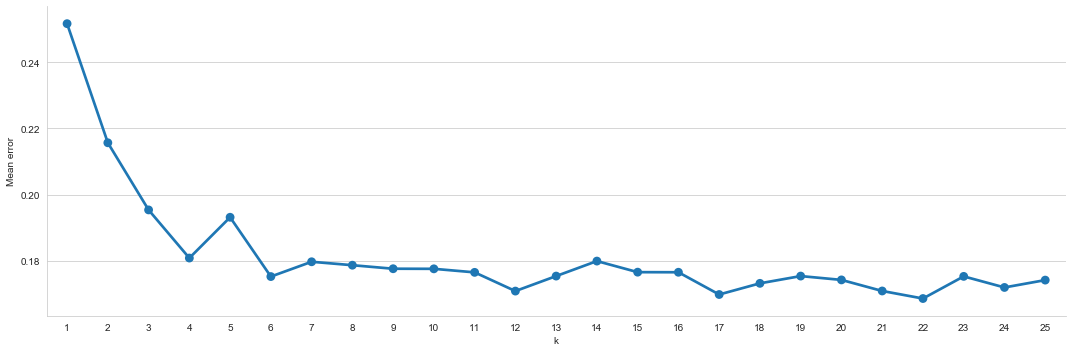

In [57]:
knn_cv_results = pd.DataFrame(gs_knn.cv_results_)
knn_cv_results['Mean error'] = 1 - knn_cv_results['mean_test_score']


p = sns.catplot(x='param_classifier__n_neighbors', y='Mean error', data=knn_cv_results, kind='point', aspect=3)
p = p.set_xlabels('k')

In [58]:
knn_best[1].n_neighbors = 10

### Decision tree

In [59]:
# decision tree tunning

dt_param_grid = {'classifier__max_depth': [None],               # None, 5, 10, 15, 20
                 'classifier__min_samples_split': [20],         # 2, 4, 8, 12, 16, 20
                 'classifier__min_samples_leaf': [15],          # 1, 5, 10, 15, 20
                 'classifier__min_weight_fraction_leaf': [0.0], # 0.0, 0.1
                 'classifier__max_features': [15],              # 'auto', 'log2', 1, 3, 5, 10, 15, 20
                }            

gs_dt = GridSearchCV(Pipeline([('scaler',  StandardScaler()),
                               ('classifier', DecisionTreeClassifier())]),
                      param_grid=dt_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)

gs_dt.fit(X_train, Y_train)

dt_best = gs_dt.best_estimator_

# best score
gs_dt.best_score_

Fitting 24 folds for each of 1 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.0s finished


0.8135075865339024

### MLP

In [60]:
# multilayer perceptron tunning

nn_param_grid = {'classifier__hidden_layer_sizes': [(25, )], # (100, ), (90, ), (80, ), (70, ), (60, ), (50, ), (40, ), (35, ), (30, ), (25, )
                 'classifier__activation': ['relu']          # 'logistic', 'tanh', 'relu'
                }

gs_nn = GridSearchCV(Pipeline([('scaler',  StandardScaler()),
                               ('classifier', MLPClassifier(solver='adam',
                                                            max_iter=1000))]), 
                     param_grid=nn_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)

gs_nn.fit(X_train, Y_train)

nn_best = gs_nn.best_estimator_

# best score
gs_nn.best_score_

Fitting 24 folds for each of 1 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   10.2s finished


0.8179824561403509

### SVM  

In [61]:
# SVM classifier tunning

svm_param_grid = {'classifier__C': [31],        # np.arange(1, 50, 3)             
                  'classifier__gamma': [0.0025] # np.logspace(1, 10, 20, base=0.5)
                 }

gs_svm = GridSearchCV(Pipeline([('scaler',  StandardScaler()),
                                ('classifier', SVC(probability=True))]),
                      param_grid=svm_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)

gs_svm.fit(X_train,Y_train)

svm_best = gs_svm.best_estimator_

# best score
gs_svm.best_score_

Fitting 24 folds for each of 1 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.7s finished


0.8325628259838785

### XGBoost

In [62]:
# XGBoost classifier tunning

xgb_param_grid = {'classifier__max_depth': [15],         # 3, 4, 5, 6, 8, 10, 12, 15
                  'classifier__learning_rate': [0.15],   # 0.05, 0.10, 0.15, 0.20, 0.25, 0.30
                  'classifier__gamma': [1.65],           # np.arange(0, 2, 0.15)
                  'classifier__min_child_weight': [3],   # 1, 3, 5, 7
                  'classifier__colsample_bytree': [0.4], # 0.4, 0.5, 0.7, 0.8
                  'classifier__reg_alpha': [0.0],        # np.linspace(0, 1, 4)
                  'classifier__reg_lambda': [1.0]        # np.linspace(0, 1, 4)
                 }

gs_xgb = GridSearchCV(Pipeline([('scaler',  StandardScaler()),
                                ('classifier', XGBClassifier())]),
                      param_grid=xgb_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gs_xgb.fit(X_train, Y_train)

xgb_best = gs_xgb.best_estimator_

# best score
gs_xgb.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 24 folds for each of 1 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.5s finished


0.8394084874348033

### Gaussian methods

In [63]:
gnb = Pipeline([('scaler',  StandardScaler()),
                ('classifier', GaussianNB())])

cv_gnb = cross_val_score(gnb, X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
      
gnb.fit(X_train, Y_train)

np.mean(cv_gnb)

0.8135075865339023

In [64]:
gpc = Pipeline([('scaler',  StandardScaler()),
                ('classifier', GaussianProcessClassifier())])

cv_gpc = cross_val_score(gpc, X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
      
gpc.fit(X_train, Y_train)

np.mean(cv_gpc)

0.8190789473684211

## Learning curves

In [65]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

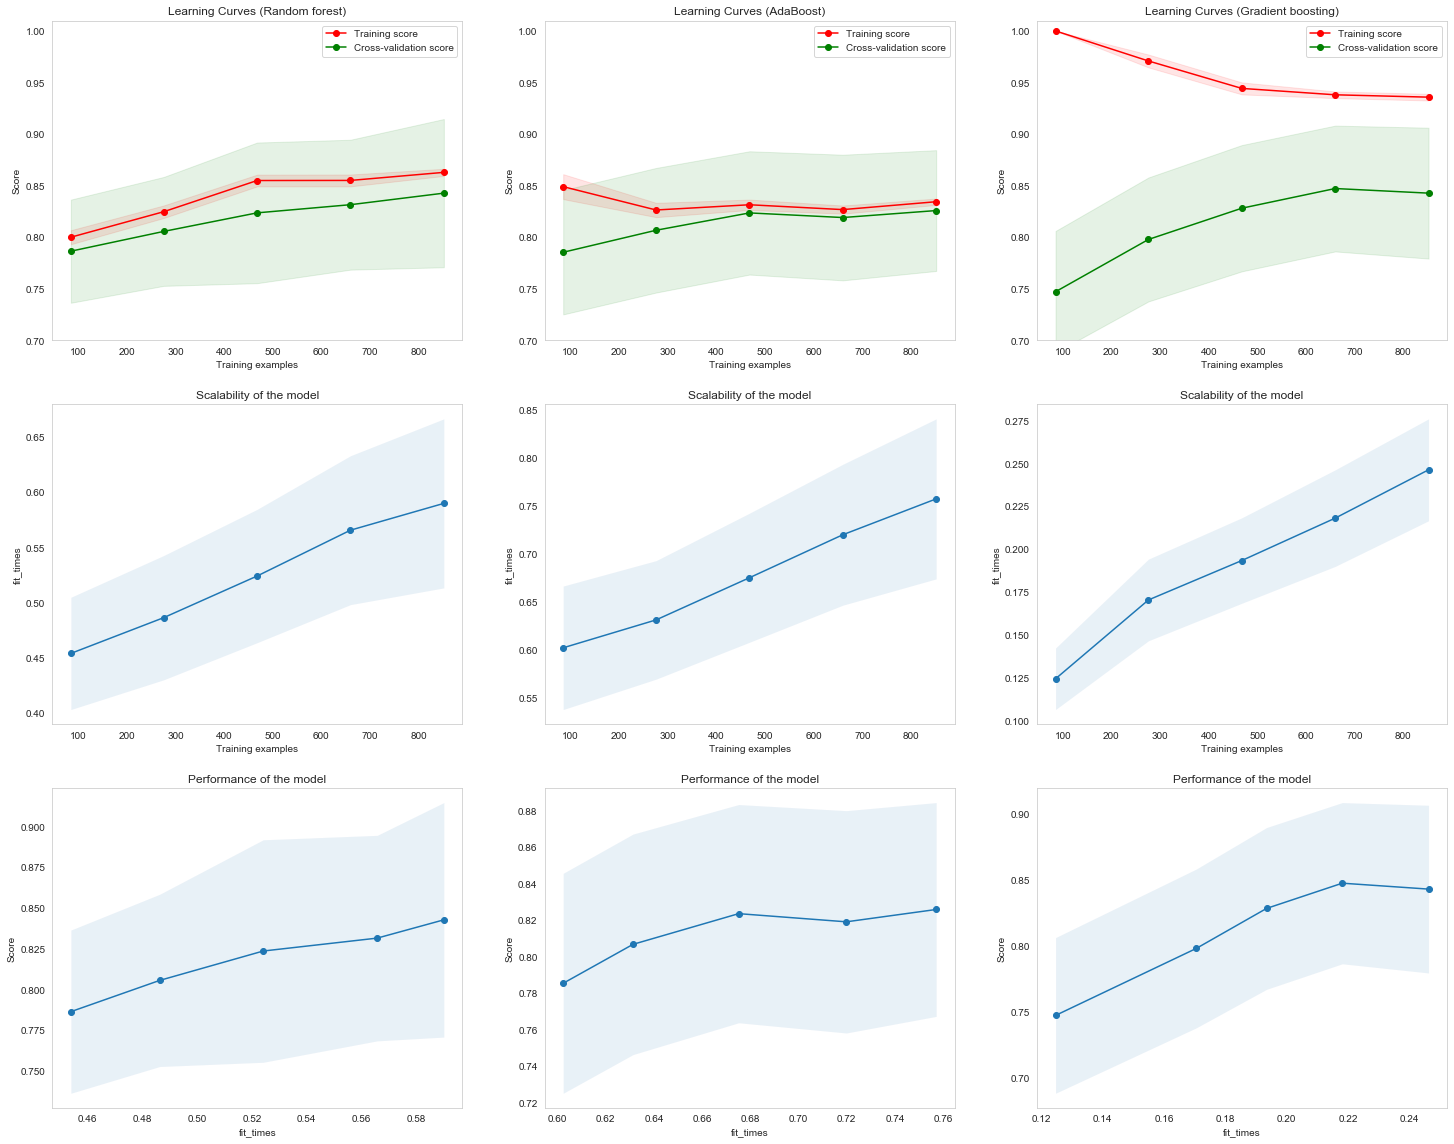

In [66]:
fig, axes = plt.subplots(3, 3, figsize=(25, 20))

title = "Learning Curves (Random forest)"
estimator = rf_best
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes[:,0], ylim=(0.7, 1.01), cv=kfold, n_jobs=-1)


title = "Learning Curves (AdaBoost)"
estimator = ada_best
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes[:,1], ylim=(0.7, 1.01), cv=kfold, n_jobs=-1)


title = "Learning Curves (Gradient boosting)"
estimator = gb_best
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes[:,2], ylim=(0.7, 1.01), cv=kfold, n_jobs=-1)

plt.show()

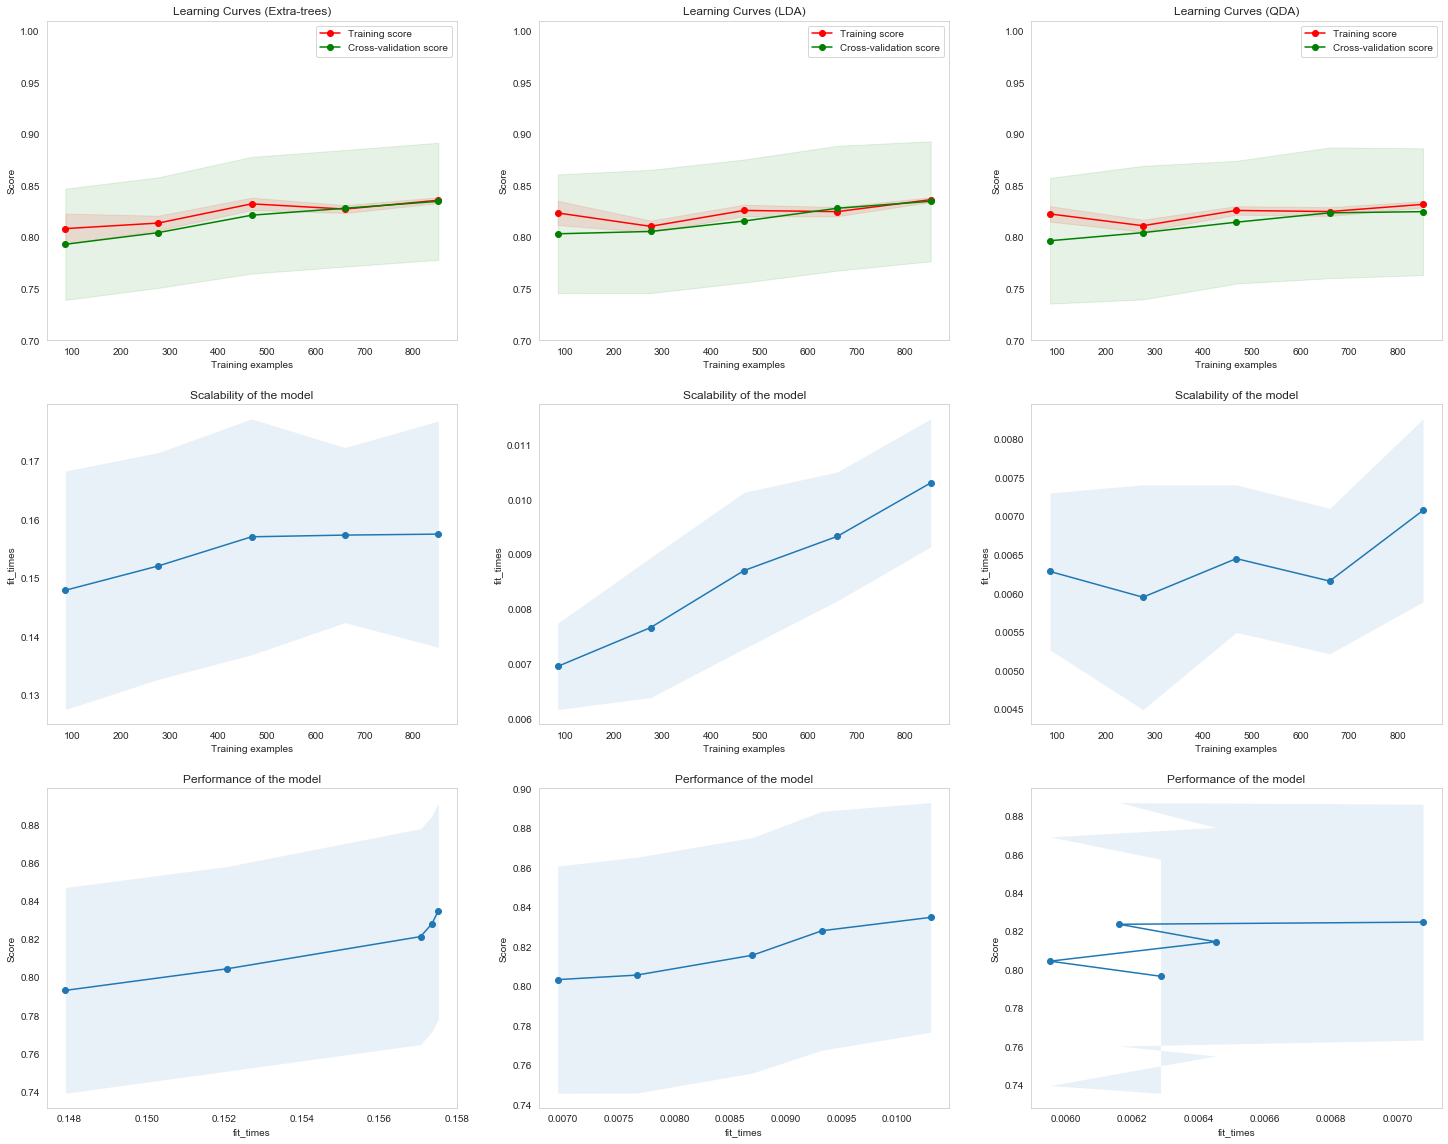

In [67]:
fig, axes = plt.subplots(3, 3, figsize=(25, 20))

title = "Learning Curves (Extra-trees)"
estimator = et_best
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes[:,0], ylim=(0.7, 1.01), cv=kfold, n_jobs=-1)


title = "Learning Curves (LDA)"
estimator = lda_best
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes[:,1], ylim=(0.7, 1.01), cv=kfold, n_jobs=-1)


title = "Learning Curves (QDA)"
estimator = qda_best
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes[:,2], ylim=(0.7, 1.01), cv=kfold, n_jobs=-1)

plt.show()

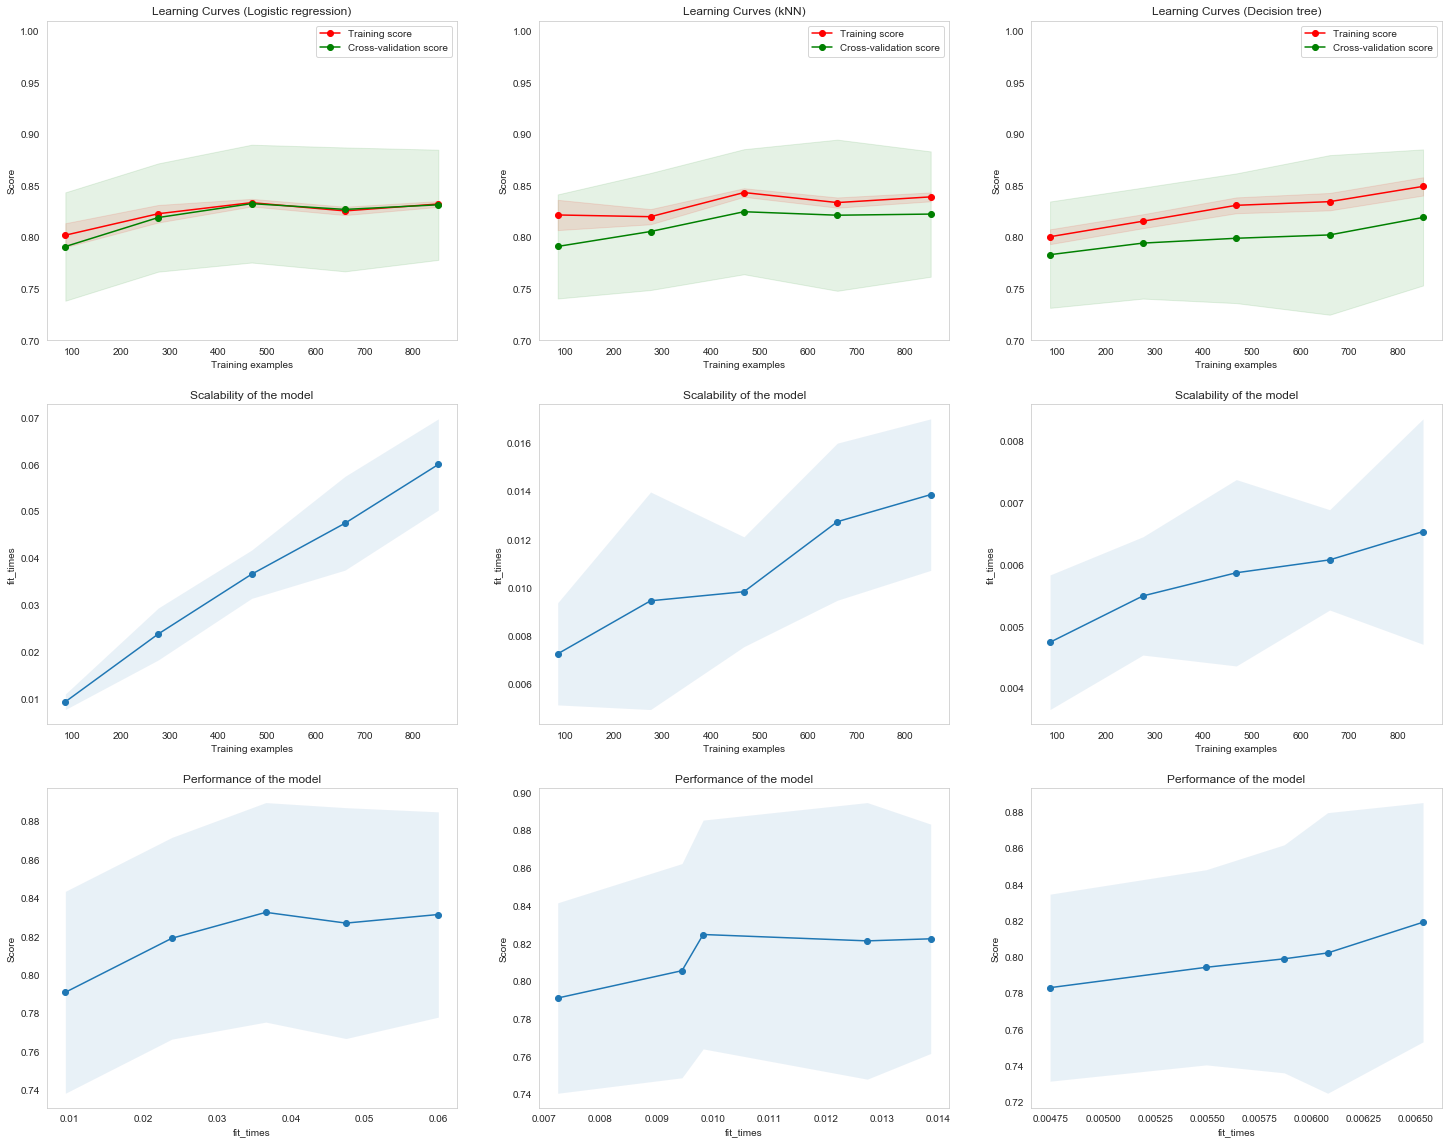

In [68]:
fig, axes = plt.subplots(3, 3, figsize=(25, 20))

title = "Learning Curves (Logistic regression)"
estimator = lr_best
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes[:,0], ylim=(0.7, 1.01), cv=kfold, n_jobs=-1)


title = "Learning Curves (kNN)"
estimator = knn_best
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes[:,1], ylim=(0.7, 1.01), cv=kfold, n_jobs=-1)


title = "Learning Curves (Decision tree)"
estimator = dt_best
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes[:,2], ylim=(0.7, 1.01), cv=kfold, n_jobs=-1)

plt.show()

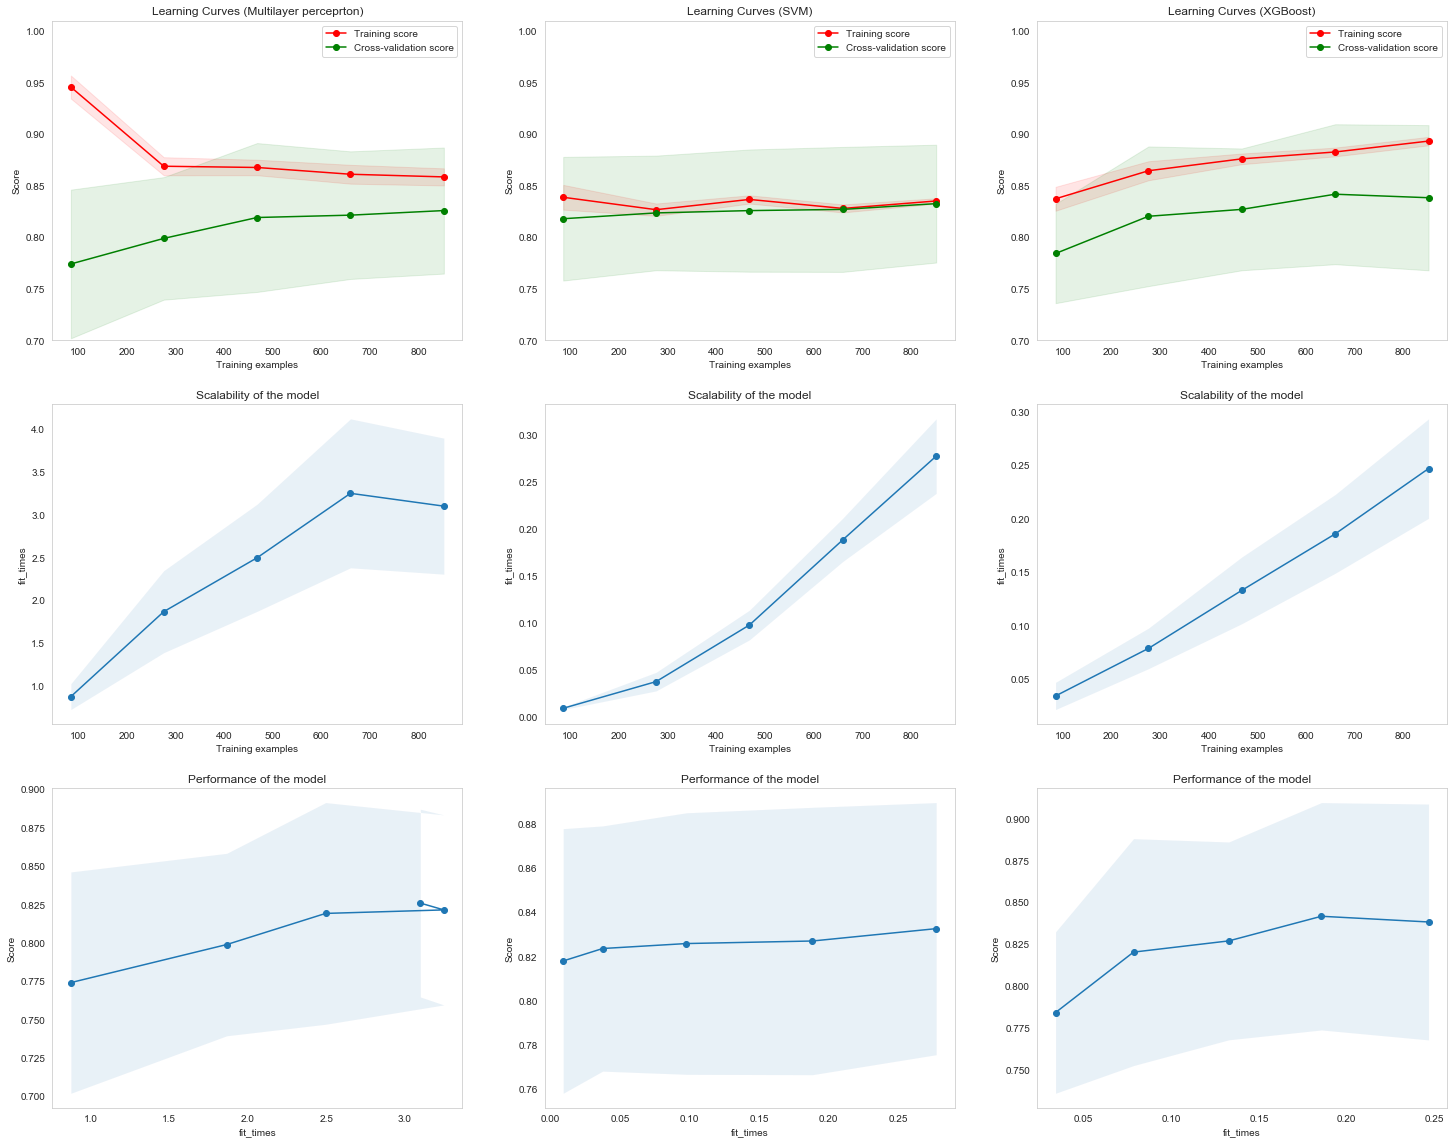

In [69]:
fig, axes = plt.subplots(3, 3, figsize=(25, 20))

title = "Learning Curves (Multilayer perceprton)"
estimator = nn_best
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes[:,0], ylim=(0.7, 1.01), cv=kfold, n_jobs=-1)


title = "Learning Curves (SVM)"
estimator = svm_best
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes[:,1], ylim=(0.7, 1.01), cv=kfold, n_jobs=-1)


title = "Learning Curves (XGBoost)"
estimator = xgb_best
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes[:,2], ylim=(0.7, 1.01), cv=kfold, n_jobs=-1)

plt.show()

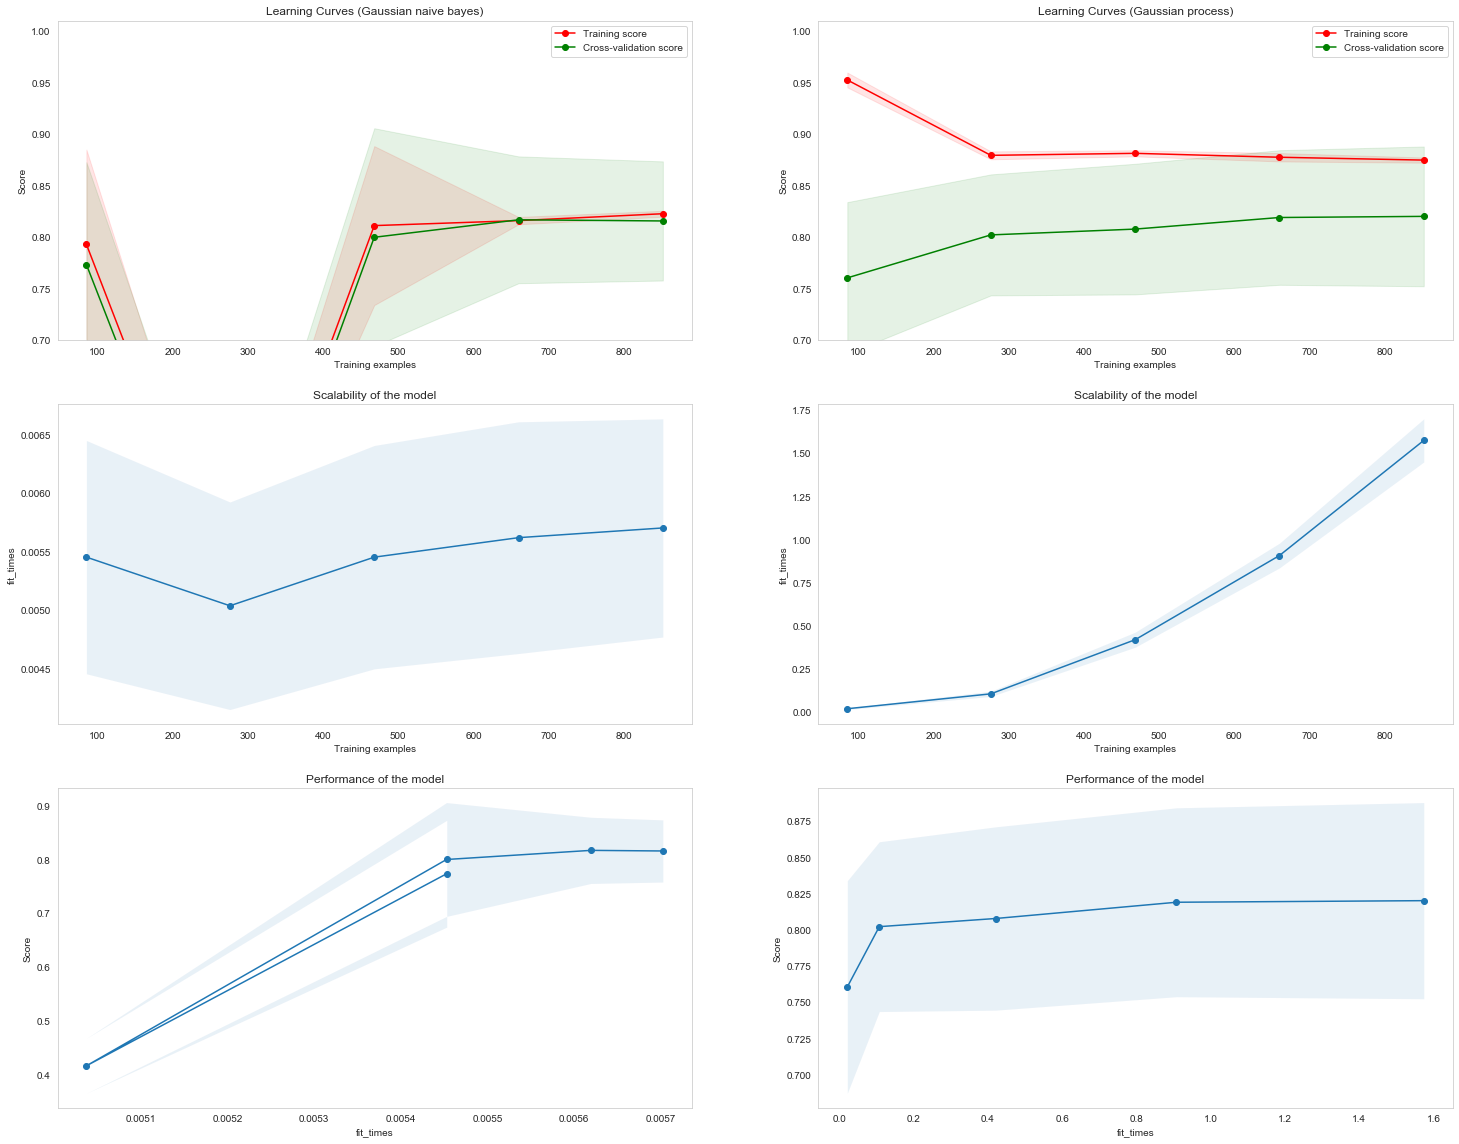

In [70]:
fig, axes = plt.subplots(3, 2, figsize=(25, 20))

title = "Learning Curves (Gaussian naive bayes)"
estimator = gnb
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes[:,0], ylim=(0.7, 1.01), cv=kfold, n_jobs=-1)


title = "Learning Curves (Gaussian process)"
estimator = gpc
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes[:,1], ylim=(0.7, 1.01), cv=kfold, n_jobs=-1)

plt.show()

##  Feature importance

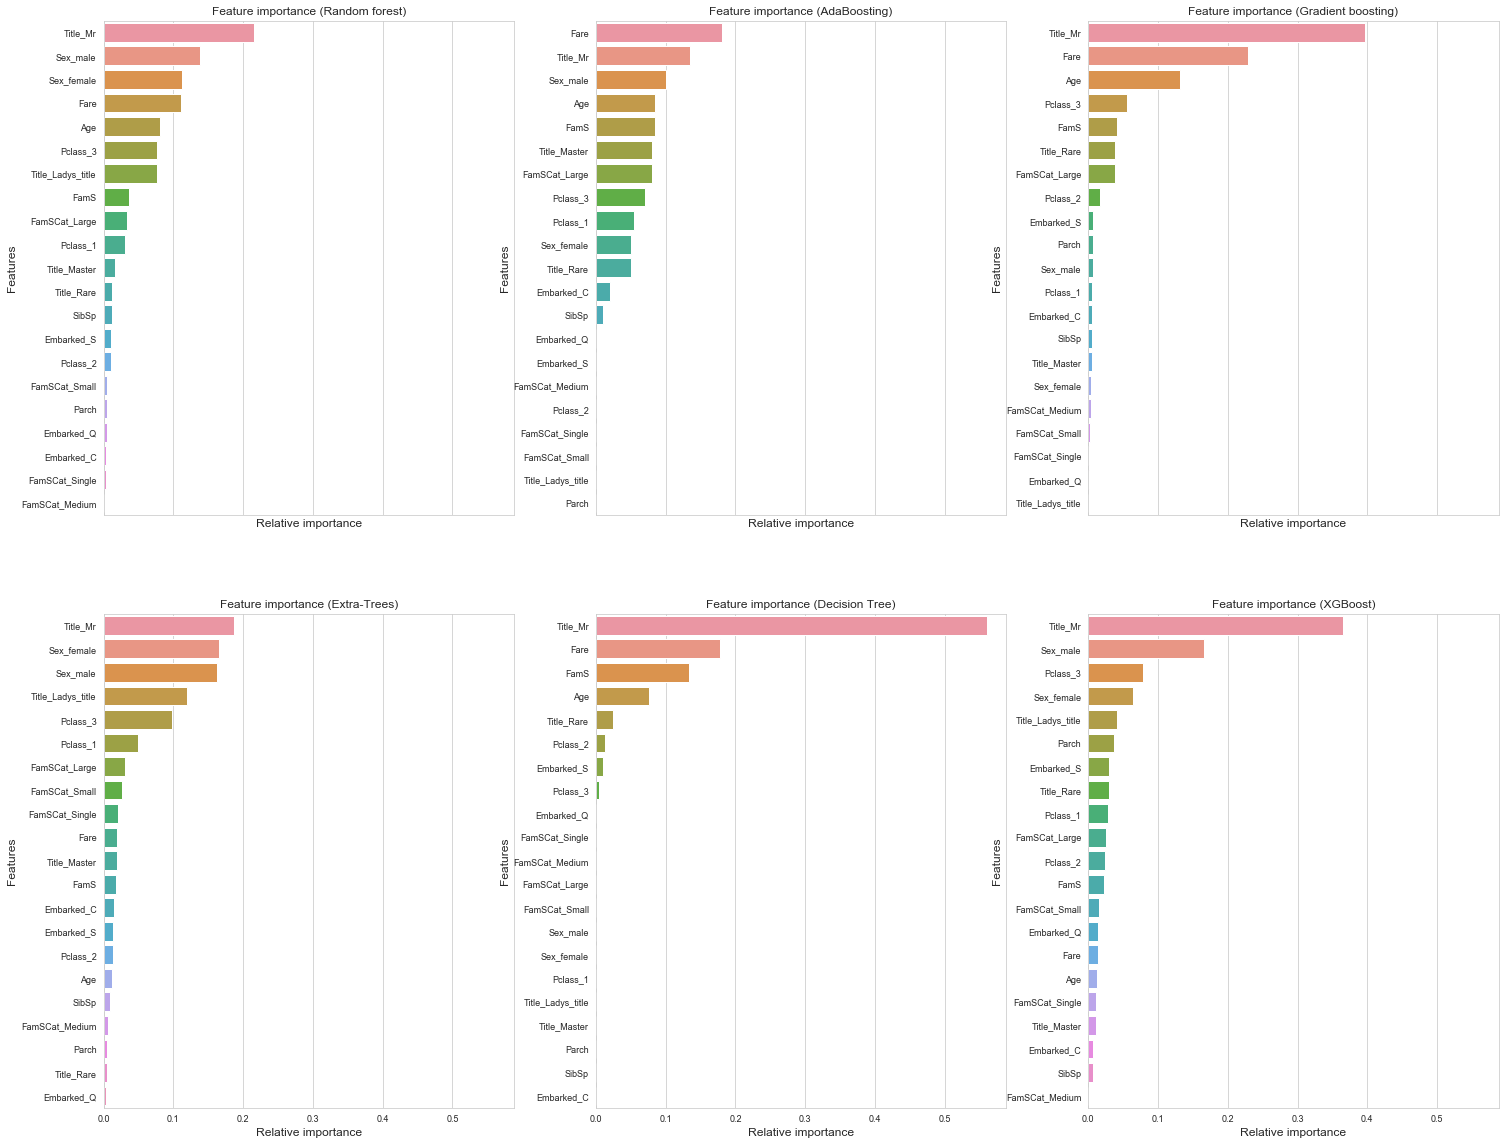

In [71]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(25,20))

names_classifiers = [("Random forest", rf_best[1]),
                     ("AdaBoosting", ada_best[1]),
                     ("Gradient boosting", gb_best[1]),
                     ("Extra-Trees", et_best[1]),
                     ("Decision Tree", dt_best[1]),
                     ("XGBoost", xgb_best[1])
                    ]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title("Feature importance (" + name + ")")
        nclassifier += 1

## Ensamble modeling

In [72]:
voting = VotingClassifier(estimators=[('RF', rf_best),
                                      ('ADA', ada_best),
                                      #('GB', gb_best),
                                      ('ET', et_best), 
                                      ('LDA', lda_best),
                                      ('QDA', qda_best),
                                      ('LR', lr_best),
                                      ('kNN', knn_best),
                                      ('DT', dt_best),
                                      ('NN', nn_best),
                                      ('SVM', svm_best),
                                      ('XGB', xgb_best),
                                      #('GNB', gnb),
                                      #('GPC', gpc)
                                      ], voting='soft', n_jobs=-1)

voting = voting.fit(X_train, Y_train)

In [73]:
cv_voting = cross_val_score(voting, X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
      
voting.fit(X_train, Y_train)

np.mean(cv_voting)

0.8258653390232338

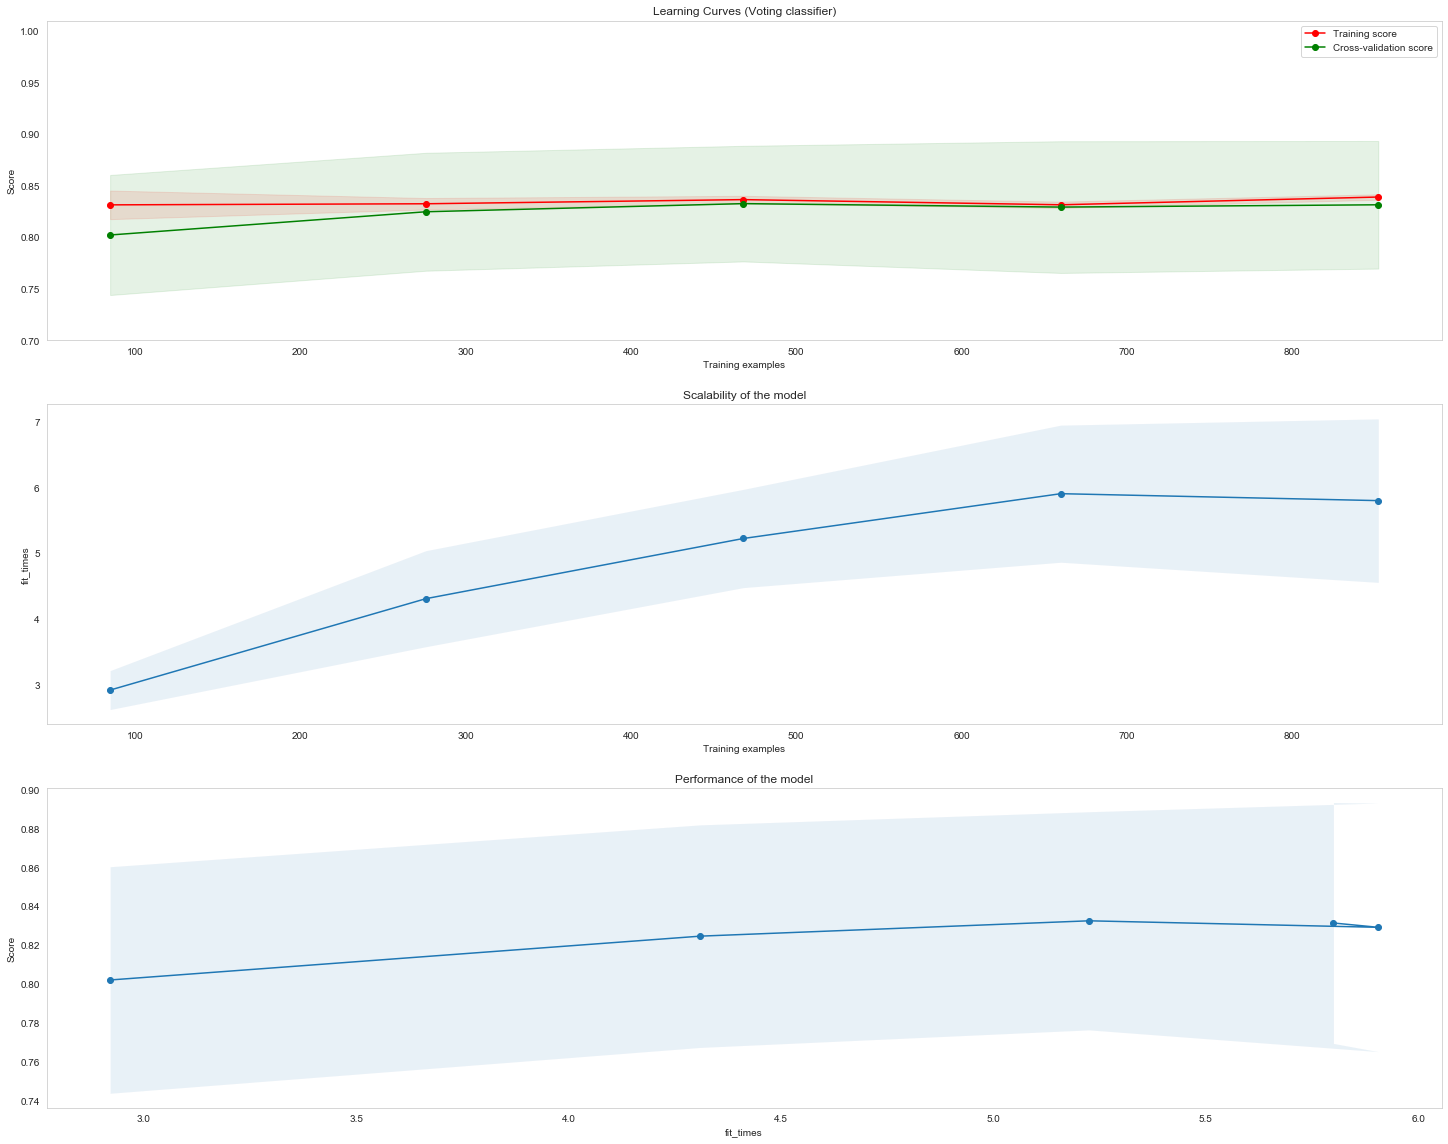

In [74]:
fig, axes = plt.subplots(3, 1, figsize=(25, 20))

title = "Learning Curves (Voting classifier)"
estimator = voting
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes, ylim=(0.7, 1.01), cv=kfold, n_jobs=-1)

plt.show()

## Prediction diffrences among models

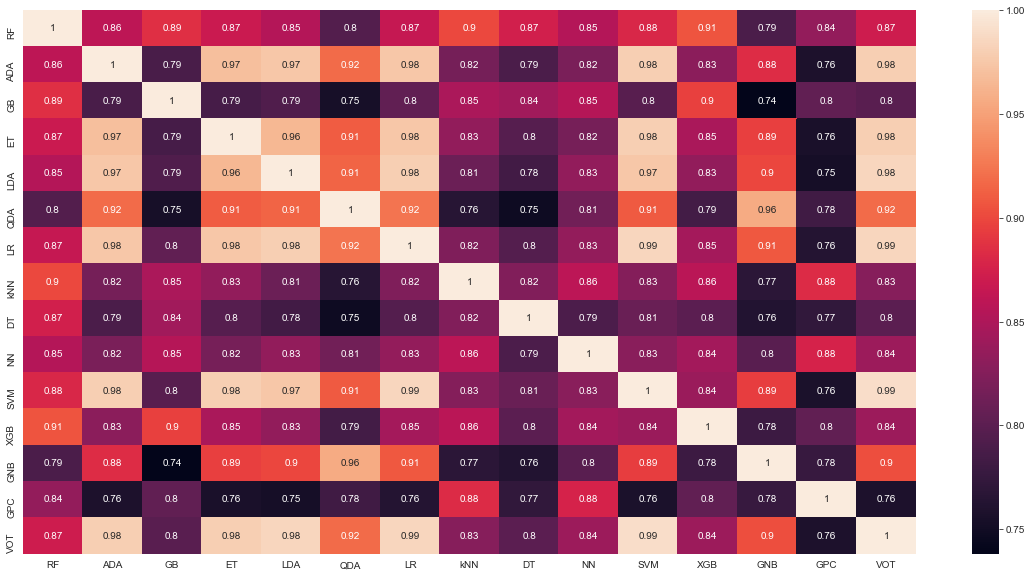

In [75]:
test_survived_rf = pd.Series(rf_best.predict(test_final), name="RF")
test_survived_ada = pd.Series(ada_best.predict(test_final), name="ADA")
test_survived_gb = pd.Series(gb_best.predict(test_final), name="GB")
test_survived_et = pd.Series(et_best.predict(test_final), name="ET")
test_survived_lda = pd.Series(lda_best.predict(test_final), name="LDA")
test_survived_qda = pd.Series(qda_best.predict(test_final), name="QDA")
test_survived_lr = pd.Series(lr_best.predict(test_final), name="LR")
test_survived_knn = pd.Series(knn_best.predict(test_final), name="kNN")
test_survived_dt = pd.Series(dt_best.predict(test_final), name="DT")
test_survived_nn = pd.Series(nn_best.predict(test_final), name="NN")
test_survived_svm = pd.Series(svm_best.predict(test_final), name="SVM")
test_survived_xgb = pd.Series(xgb_best.predict(test_final), name="XGB")
test_survived_gnb = pd.Series(gnb.predict(test_final), name="GNB")
test_survived_gpc = pd.Series(gpc.predict(test_final), name="GPC")

test_survived_vot = pd.Series(voting.predict(test_final), name="VOT")


# concatenate all classifier results
ensemble_results = pd.concat([test_survived_rf,
                              test_survived_ada,
                              test_survived_gb,
                              test_survived_et,
                              test_survived_lda,
                              test_survived_qda,
                              test_survived_lr,
                              test_survived_knn,
                              test_survived_dt,
                              test_survived_nn,
                              test_survived_svm,
                              test_survived_xgb,
                              test_survived_gnb,
                              test_survived_gpc,
                              test_survived_vot
                             ], axis=1)


fig, ax = plt.subplots(figsize=(20,10))
p = sns.heatmap(ensemble_results.corr(), annot=True, ax=ax)

## Final prediction

In [76]:
i = 1
for result in ensemble_results:
    results = pd.concat([test["PassengerId"], ensemble_results[result]], axis=1)
    results.columns = ['PassengerId', 'Survived']
    results.to_csv('.\\02 Deliverables\\' + str(i).zfill(2) + '_' + result + ".csv", index=False)
    i = i+1